<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab12-NLP-towards-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 12 - Natural Language Processing - Towards Attention


### Author: Szymon Nowakowski


# Introduction
---------------
In this class, we take our first steps into Natural Language Processing (NLP). We'll begin by averaging word embeddings to form sentence-level representations—a simple but effective baseline. **Attention** generalizes this idea by learning which words matter more in context, assigning dynamic weights instead of treating each word equally. In this sense, **attention can be thought of as a learned, weighted average**.

This is our gateway into more advanced techniques. In the next class, we’ll study **self-attention**, the backbone of modern architectures like the Transformer.




## Acknowledgments

*I would like to express my gratitude to my colleague **Przemysław Olbratowski** for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.*

# Yelp Reviews Polarity Dataset  
--------------

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [3]:
#!pip install -U datasets

In [4]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 100_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)



Train distribution:
  0: 50209 (50.21%)
  1: 49791 (49.79%)

Validation distribution:
  0: 5038 (50.38%)
  1: 4962 (49.62%)

Test distribution:
  0: 4973 (49.73%)
  1: 5027 (50.27%)


## Some examples

In [5]:
label_map = {0: "negative", 1: "positive"}

for i in range(10):
    print(f"[{label_map[train_labels[i]]}] {train_texts[i]}\n")

[positive] Decent size, decent selection, decent staff.\n\nI guess that can wholly sum this place up, it's decent.  As with many other stores that are like this, the product rotates depending on what doesn't sale well at other stores.  Can always snag a deal here.  I was able to pick up a pretty sweet Puma jacket for $10, can't beat that, right?\n\nThat being said, there are those times that you may not find anything as well.  So really don't get your hopes up if you are looking for a specific item.

[negative] I have definitely experienced better! Let's see, so I first brought my car here to get the brakes done and they did a pretty good job, although, every time I'm in reverse, my brakes do make a squeaking noise. Not sure what's up with that. Anyway, needless to say, they did a pretty good job on my brakes. \n\nSince my last brake job, they have switched managers and the service has kinda gone down hill. I brought my car in to have the control arm bushings done. They quoted me a lit

# Tokenizer
-------------------

To feed text into a neural network, we need to represent words in a "neural-network-ish" way — that is, as numbers. The standard approach is to use a tokenizer, often from a pretrained model. However, since we plan to experiment with our own attention modules later on, **we’ll avoid using any pretrained tokenizer**.

Instead, we’ll go with a simple, word-based tokenization. As part of this, we’ll clean the text by removing any non-standard HTML tags, digits, extra whitespace, and punctuation. We’ll also convert all words to lowercase to ensure consistency.

## Special Tokens: `<PAD>` and `<UNK>`

In our text preprocessing pipeline, we convert each word to a number using a vocabulary. Two special tokens help us handle padding and unknown words.




### `<PAD>` — Padding Token

- Represents empty slots when we need all input sequences to be the same length.
- Assigned index `0`.
- Used so that batches of sentences can be processed together by the model.

*For example:*

Original: `[17, 5, 23]`  
Padded:   `[17, 5, 23, 0, 0]` (for a fixed length of 5)




### `<UNK>` — Unknown Token

- Represents any word that is **not in the vocabulary**.
- Assigned index `1`.
- Occurs when:
  1. A word was **too rare in the training data** (appeared only once and was excluded from the vocabulary).
  2. A word appears **only in validation or test data**.

> In our setup, we **excluded all words that appear only once** in the training set.  
> So even in the training data, some tokens are replaced with `<UNK>`.  
> These are called **rare unknowns** — they help the model learn how to handle unusual or unfamiliar words.


By including `<UNK>` during training, we teach the model how to deal with unseen or rare words at test time — which is **crucial for generalization**.


In [6]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break


Original:   I've been to Benihannas several times in a California and Arizona. I must say that there isn't any consistency with this place. The one here in chandler is not very good. I think they are surviving off of the reputation not customer service. First the girl working as the hostess needs to learn how to smile and actually act like she likes her job. Word of advice for her. If you can't smile, be cordial, have a personality then quit and find another line of work but obviously interacting with the public is not your calling. \n\nVery long wait to eat.... The servers are slow and you have to wait forever just to get drinks and refills...\n\nI think for $100 I can spend it elsewhere and get better service and food...
Tokenized:  ['i', 've', 'been', 'to', 'benihannas', 'several', 'times', 'in', 'a', 'california', 'and', 'arizona', 'i', 'must', 'say', 'that', 'there', 'isn', 't', 'any', 'consistency', 'with', 'this', 'place', 'the', 'one', 'here', 'in', 'chandler', 'is', 'not', 've

## Notice!

Notice that the `<UNK>` token (coded as 1) is visible in the rows above. Also, there is an abundance of `<PAD>` tokens (coded as 0).

# Prepare Data Loaders
--------------------

We must transform the pandas dataframe to the dataset - it will, among other things, separate input data and labels and then wrap it in a dataloder.

In [7]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Training Loop as We Already Got to Know It Well
----------------

## Train Loop Function

In [8]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cuda


## Plot Function

In [9]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Simple 1 Feature Aproach
------------------

Before we proceed with a multi-feature network, let's try to go simpler, for a moment. Let's consider a single feature.

Working on cuda
Epoch 000 | Train Loss: 0.7007, Acc: 0.4979 | Val Loss: 0.6985, Acc: 0.4962
Epoch 010 | Train Loss: 0.6517, Acc: 0.6052 | Val Loss: 0.6466, Acc: 0.6161
Epoch 020 | Train Loss: 0.5326, Acc: 0.7709 | Val Loss: 0.5270, Acc: 0.7757
Epoch 030 | Train Loss: 0.4468, Acc: 0.8232 | Val Loss: 0.4453, Acc: 0.8217
Epoch 040 | Train Loss: 0.3886, Acc: 0.8521 | Val Loss: 0.3905, Acc: 0.8478
Epoch 050 | Train Loss: 0.3455, Acc: 0.8712 | Val Loss: 0.3507, Acc: 0.8667
Epoch 060 | Train Loss: 0.3124, Acc: 0.8856 | Val Loss: 0.3211, Acc: 0.8786
Epoch 070 | Train Loss: 0.2864, Acc: 0.8954 | Val Loss: 0.2989, Acc: 0.8876
Epoch 080 | Train Loss: 0.2657, Acc: 0.9032 | Val Loss: 0.2822, Acc: 0.8931
Epoch 090 | Train Loss: 0.2491, Acc: 0.9090 | Val Loss: 0.2696, Acc: 0.8969
Epoch 100 | Train Loss: 0.2355, Acc: 0.9141 | Val Loss: 0.2604, Acc: 0.9018
Epoch 110 | Train Loss: 0.2243, Acc: 0.9178 | Val Loss: 0.2536, Acc: 0.9041
Epoch 120 | Train Loss: 0.2148, Acc: 0.9215 | Val Loss: 0.2488, Acc: 0.9

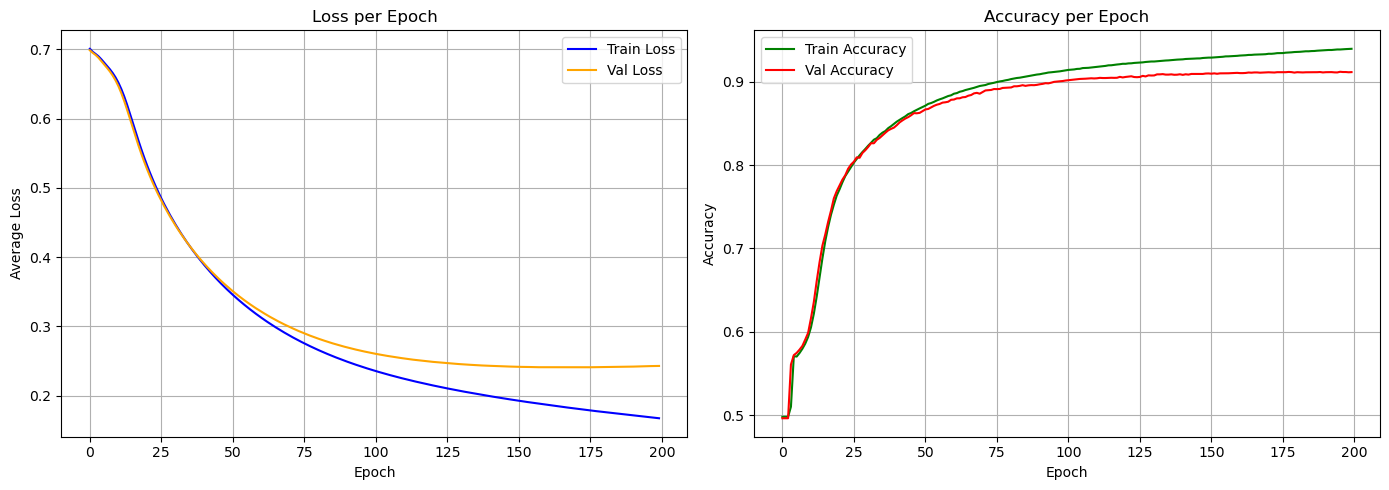

In [10]:
feature_cnt = 1
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_1 = Net_1()

# Execute training
train_loss, val_loss, train_acc, val_acc = train_model(net_1, train_loader, val_loader, epochs = 200)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Sentiment Polarity

Since our embeddings have only 1 feature (`feature_cnt = 1`), each word is embedded to a scalar. We can interpret this scalar as a kind of sentiment polarity, especially since our model is trained for sentiment classification.

In [11]:
import numpy as np

# Get the embedding weights as a NumPy array
embedding_weights = net_1.embedding.weight.detach().cpu().numpy().squeeze()  # shape: (vocab_len,)

# Reverse vocab dictionary to map indices back to words
id2token = {idx: token for token, idx in vocab.items()}

# Skip <PAD> and <UNK> tokens (indices 0 and 1)
valid_indices = np.array([idx for idx in range(2, len(embedding_weights)) if idx in id2token])
valid_embeddings = embedding_weights[valid_indices]

# Sort and select indices
sorted_pos = np.argsort(-valid_embeddings)
sorted_neg = np.argsort(valid_embeddings)
sorted_neutral = np.argsort(np.abs(valid_embeddings))

top_pos_indices = valid_indices[sorted_pos[:20]]
top_neg_indices = valid_indices[sorted_neg[:20]]
top_neutral_indices = valid_indices[sorted_neutral[:20]]

# Print words and corresponding embedding values
def print_words_with_embeddings(indices, title):
    print(f"\n{title}")
    for idx in indices:
        word = id2token[int(idx)]
        value = embedding_weights[int(idx)]
        print(f"{word:15} -> {value:.4f}")

print_words_with_embeddings(top_pos_indices, "Top 20 most positive words:")
print_words_with_embeddings(top_neg_indices, "Top 20 most negative words:")
print_words_with_embeddings(top_neutral_indices, "Top 20 most neutral words:")



Top 20 most positive words:
delicious       -> 13.2235
excellent       -> 12.7576
phenomenal      -> 12.7009
awesome         -> 12.2002
fantastic       -> 11.9967
pleasantly      -> 11.8967
amazing         -> 11.7529
perfection      -> 11.6419
gem             -> 11.4302
ngreat          -> 11.3560
incredible      -> 11.2053
yum             -> 11.0856
perfect         -> 10.7907
glad            -> 10.2746
perfectly       -> 9.9910
yummy           -> 9.9270
addicted        -> 9.8642
wonderful       -> 9.5822
pleased         -> 9.5092
superb          -> 9.4010

Top 20 most negative words:
mediocre        -> -16.5915
bland           -> -16.3095
worst           -> -15.1473
horrible        -> -14.6822
disgusting      -> -14.6809
disappointing   -> -14.3393
terrible        -> -14.3263
meh             -> -13.8851
overpriced      -> -13.3517
tasteless       -> -12.8738
awful           -> -12.5062
unfortunately   -> -12.2981
unimpressed     -> -12.1688
poorly          -> -12.1054
rude            

## Classificator

It is interesting to see how the polar sentiment gets translated into the two  class values. Let's see:

In [12]:
# Extract weights and bias from the classifier layer
classifier_weight = net_1.classifier.weight.detach().cpu().numpy()
classifier_bias = net_1.classifier.bias.detach().cpu().numpy()

print("Classifier weights (shape: {}):".format(classifier_weight.shape))
print(classifier_weight)

print("\nClassifier bias (shape: {}):".format(classifier_bias.shape))
print(classifier_bias)

print("Recall our coding: ")
print(label_map)


Classifier weights (shape: (1, 1)):
[[14.786245]]

Classifier bias (shape: (1,)):
[-0.9344498]
Recall our coding: 
{0: 'negative', 1: 'positive'}


In [13]:
# Hand-picked test sentences
texts = [
    "I love this",
    "I like this",
    "I do not like this",
    "I don't like this",
    "This is terrible",
    "Thank you so much!",
    "I hate this",
    "I don't hate this",
    "This sucks!"
]

# Convert texts to input_ids using your tokenizer
input_ids = process_texts(texts, vocab)
input_tensor = torch.tensor(input_ids).to(next(net_1.parameters()).device)

# Predict with trained model
net_1.eval()
with torch.no_grad():
    logits = net_1(input_tensor).squeeze()
    probs = torch.sigmoid(logits)

# Print results
for text, prob in zip(texts, probs):
    print(f"{text:30} -> predicted probability of POSITIVE: {prob.item():.4f}")


I love this                    -> predicted probability of POSITIVE: 0.7463
I like this                    -> predicted probability of POSITIVE: 0.5497
I do not like this             -> predicted probability of POSITIVE: 0.3569
I don't like this              -> predicted probability of POSITIVE: 0.4834
This is terrible               -> predicted probability of POSITIVE: 0.1831
Thank you so much!             -> predicted probability of POSITIVE: 0.7319
I hate this                    -> predicted probability of POSITIVE: 0.4095
I don't hate this              -> predicted probability of POSITIVE: 0.3470
This sucks!                    -> predicted probability of POSITIVE: 0.2298


# Adding Artificial (Concatenated) Sentences
-----------------

It will make the dataset diffinitely more demanding and also more suited for attention that we intend to add later.

Every original sentence appears as the second part of a mixed sentence, so every label is retained. Next, a second randomly selected sentence is prepended — that is, added to the beginning of the original sentence. As an effect, we generate as many augmented samples as there are originals. The number of samples and the label distribution is retained.

The classifier must learn to focus on the main sentence and ignore the distractor that is added. This provides a clear, controlled task that makes attention valuable:
 - **With attention**: the model can learn to give weight to the main part. It must also learn to disregard `<PAD>` tokens that follow.
 - **Without attention**: a mean-pool model may be diluted by the additional sentence.

In [14]:

import random

MAX_LEN = 256  # changing max len to accomodate longer sequences, also, longer sequences are harder for the mean network

def pair_every_sentence_with_random(texts, labels, seed=42):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)

# Reprocess splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Recalculate data loaders
train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# More Features, Now
---------------

Working on cuda
Epoch 000 | Train Loss: 0.6858, Acc: 0.5468 | Val Loss: 0.6795, Acc: 0.5676
Epoch 010 | Train Loss: 0.5007, Acc: 0.7971 | Val Loss: 0.5133, Acc: 0.7930
Epoch 020 | Train Loss: 0.4701, Acc: 0.8135 | Val Loss: 0.4998, Acc: 0.8036
Epoch 030 | Train Loss: 0.4543, Acc: 0.8206 | Val Loss: 0.4994, Acc: 0.8029
Epoch 040 | Train Loss: 0.4419, Acc: 0.8254 | Val Loss: 0.5030, Acc: 0.8014
Elapsed time: 170.35 seconds


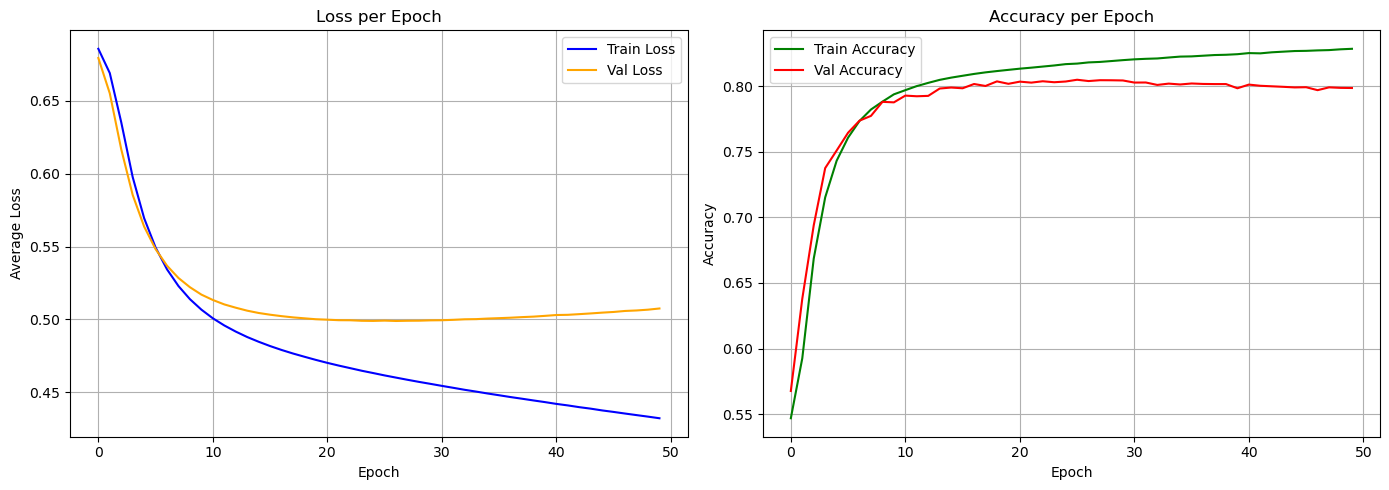

In [15]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #batch, words
        features = self.embedding(index)             #batch, words, features
        features = features.mean(-2)                 #batch, features
        classifications = self.classifier(features)  #batch, 1
        logits = classifications.squeeze(-1)         #batch
        return logits

net_f=Net_F()
train_loss, val_loss, train_acc, val_acc = train_model(net_f, train_loader, val_loader, epochs=50)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Attention!
---------------------------


## The Entry Point

The entry point is our model with averaged multiple features:

In [16]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #SIZE: batch, words
        features = self.embedding(index)             #SIZE: batch, words, features

        ### This is where AVERAGING takes place
        features = features.mean(-2)                 #SIZE: batch, features


        classifications = self.classifier(features)  #SIZE: batch, 1
        logits = classifications.squeeze(-1)         #SIZE: batch
        return logits

## Less Explicit Averaging

The code below is equivalent to taking the `mean()` over words:

In [17]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features


        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

And now let us refactor this, taking the weighted average part into a separate `Attention` module:

In [18]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                         #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        weights = torch.ones((batch, 1, words)) / words   # create EQUAL WEIGHT tensor summing to 1.0 ( words x (1/words) )
                                                         #SIZE: batch, 1, words
        features = weights @ features                    #SIZE: batch, 1, features
        return features

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

All that we did up until that point was to rewrite taking the `mean()` into a separate `Attention` which calculates the weighted averager with equal weights over weights.

## Introducing the Notion of Energy

Another useful concept is that of the energy. The energy equal to 0 uniformly for all words translates (with the use of `softmax`) into the equal weights, so the below version is still equivalent to what we already had (but, arguably, it looks much more complex):

In [19]:
import torch.nn.functional as F

feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = torch.zeros((batch, 1, words))       #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Towards_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with EQUAL WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

## Something New - Learned Energies

Working on cuda
Epoch 000 | Train Loss: 0.6737, Acc: 0.5796 | Val Loss: 0.6382, Acc: 0.6362
Epoch 010 | Train Loss: 0.4104, Acc: 0.8122 | Val Loss: 0.4315, Acc: 0.8043
Epoch 020 | Train Loss: 0.3712, Acc: 0.8318 | Val Loss: 0.4502, Acc: 0.7970
Epoch 030 | Train Loss: 0.3408, Acc: 0.8458 | Val Loss: 0.5039, Acc: 0.7861
Epoch 040 | Train Loss: 0.3211, Acc: 0.8542 | Val Loss: 0.5670, Acc: 0.7785
Elapsed time: 162.92 seconds


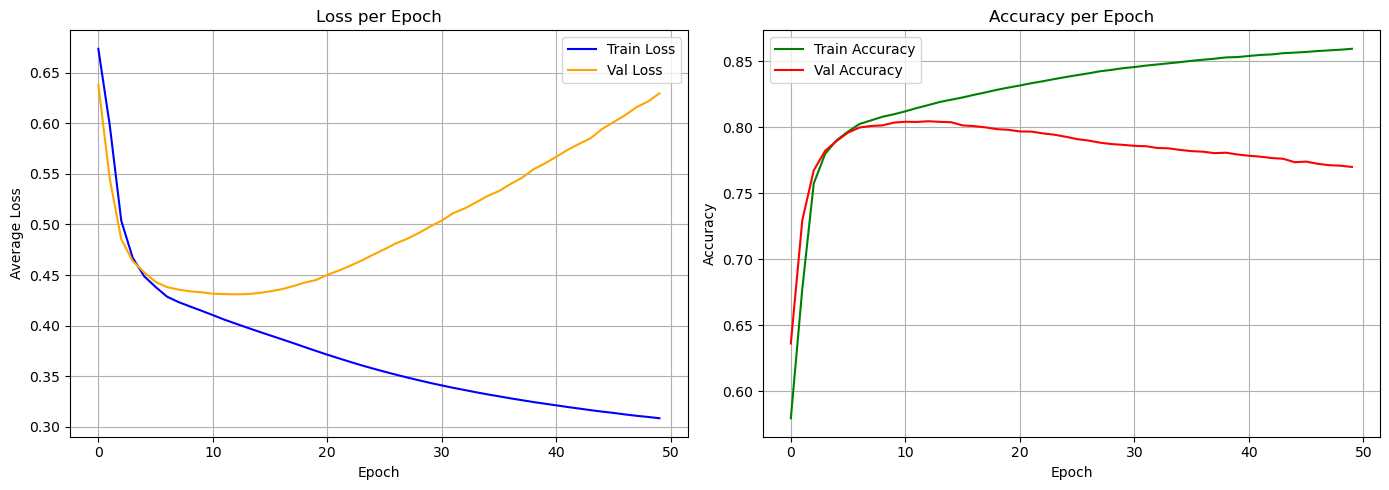

In [20]:
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, feature_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index)                 #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att = Net_Attention()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att, train_loader, val_loader, epochs = 50)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Positional Encoding
-----------------------

In [21]:
import torch

pos_cnt = 16
positional_encoding_B = 1000

def sinusoid_positions(max_len = MAX_LEN, dim = pos_cnt):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: words, features  (constant matrix throuoght all computations)





Each position in the sequence gets a vector that is added (or concatenated) to the word embedding. The values in that vector are defined deterministically using sine and cosine waves of varying frequencies.

For a given position $pos$ and dimension $i$ (where $i$ goes from $0$ to $d_{\text{model}} - 1$):

$$
\text{PE}_{pos, i} =
\begin{cases}
\sin\left(\frac{pos}{B^{i / d_{\text{model}}}}\right), & \text{if } i \text{ is even} \\
\cos\left(\frac{pos}{B^{(i - 1) / d_{\text{model}}}}\right), & \text{if } i \text{ is odd}
\end{cases}
$$

with $B=10,000$, typically.



**Why use sine and cosine?**

- **Smoothness**: adjacent positions have similar encodings — helpful for capturing local context.
- **Distance-preserving**: differences between position encodings reflect relative distances, which helps the attention mechanism.
- **No training needed**: the encoding is deterministic, so it generalizes to sequences longer than those seen during training.


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create sinusoidal matrix S
S = sinusoid_positions() # size: words, features

# Separate sine (even) and cosine (odd) components
sine = S[:, ::2]
cosine = S[:, 1::2]
gap = torch.full((S.size(0), 1), float('nan')).to(device)  # vertical separator

# Concatenate: [sine | gap | cosine]
S_sep = torch.cat([sine, gap, cosine], dim=1)

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S_sep.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings (Sine | Cosine)")
plt.xlabel("Embedding dimension (sine for even | gap | cosine for odd)")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()



ModuleNotFoundError: No module named 'seaborn'

In [ ]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att_pe = Net_Attention_And_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att_pe, train_loader, val_loader, epochs = 20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

In [ ]:
embed_cnt = 16          # word embeddings
pos_cnt = 16             # pos embeddings
feature_cnt = 16
vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Net_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                        #SIZE: batch, words
        features = self.embedding(index) + S         #SIZE: batch, words, features

        ### This is where AVERAGING takes place
        features = features.mean(-2)                 #SIZE: batch, features

        classifications = self.classifier(features)  #SIZE: batch, 1
        logits = classifications.squeeze(-1)         #SIZE: batch
        return logits

net_pe = Net_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_pe, train_loader, val_loader, epochs = 50)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

## Conclusion

**Attention-based models outperform non-attention models**, even when positional encoding is included in the latter.

But does that mean a non-attention model is **incapable** of learning which words and positions are important and how they relate to sentiment polarity?

**Not necessarily.**  
Especially with more depth, a regular network could still learn to associate **word importance** with **sentiment signals**. It can, in principle, learn both at once.

However, the advantage of attention is that it **explicitly separates** these two aspects:
- the **informational content** of the input, and  
- the **relative importance** of different parts.

This division simplifies the learning process and makes the model's behavior more interpretable.

There are other examples, where embedding known mathematical structure
makes learning easier, faster, and more efficient.  
**Don’t let the network relearn what you can hard-code for free.**

The two examples will follow:
- output range constraint
- a Green function for PINNs

### Result in (0,1)

This is conceptually similar to applying a **sigmoid** to the output of a neural network  
if we know the target should lie in $(0, 1)$ — we let the network focus only on the hard part, instead of having it rediscover itself that the result is in (0,1).



### Green function

A **Green function** is a fundamental solution used to solve linear differential equations with boundary conditions.  
It represents the **response of the system** (e.g., vibrating string, heat rod) to a **unit point source** located at position $\xi$.

Once the Green function $G(x, \xi)$ is known, the solution to the full problem with an arbitrary source function $f(\xi)$ can be written as:

$$
u(x) = \int_{\Omega} G(x, \xi)\, f(\xi)\, d\xi + \text{(boundary terms)}.
$$

This turns the differential equation into an **integral equation**, which is often more stable or efficient to solve numerically.  
The Green function $G(x, \xi)$ is fully determined by the PDE and boundary conditions.  
The only unknown is the source term $f(\xi)$ (or possibly a coefficient field).





#### How It's Used in a PINN (Physics-Informed Neural Network)

PINNs are neural network used to solve differential equations arising in physics.

**Give the network the easy part for free.**  
If you already know the Green function, you can embed it into the model output:

$$
u_\theta(x) = \int_{\Omega} G(x, \xi)\, N_\theta(\xi)\, d\xi + \text{(boundary term)},
$$

where $N_\theta$ is a neural network that learns only the **residual source** $f(\xi)$.  
We then train $N_\theta$ by minimizing the PDE residual.

Because the Green function already builds in the correct inverse operator and boundary behavior,  
the network no longer wastes capacity trying to learn what we already know.

## Attention Weights Exploration



Now that our attention-based model is trained, and is superior to non-attention model, let's take a closer look at what it's *actually attending to*. We'll manually construct artificial embeddings containing:

- A strongly positive word (`delicious`)
- A strongly negative word (`disappointing`)
- A neutral word (`delivery`)
- A padding token (`<PAD>`)

plus the positional encoding for all positions.

Each word will be passed through the model along with positional encodings.

We'll then extract and chart the raw attention **energies** that the network computes **before softmax** — showing how much each word is prioritized in the weighted average.


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Words to test
probe_words = ["delicious", "disappointing", "delivery", "<PAD>"]

# Evaluate in no-grad mode
net_att_pe.eval()
with torch.no_grad():
    for word in probe_words:
        token_idx = vocab.get(word, vocab["<UNK>"])
        token_embed = net_att_pe.embedding(torch.tensor([token_idx]).to(device)) # size: 1, features

        energies = []
        for pos in range(MAX_LEN):
            pos_enc = S[pos]                                          # size: features
            full_input = token_embed + pos_enc                        # size: 1, features
            energy = net_att_pe.attention.energy(full_input)          # size: 1, 1
            energies.append(energy.item())

        # Plot the energy across positions
        plt.figure(figsize=(8, 3))
        plt.plot(range(MAX_LEN), energies)
        plt.title(f"Attention Energy vs. Position — {word}")
        plt.xlabel("Position (pos_enc index)")
        plt.ylabel("Raw Attention Energy")
        plt.grid(True)
        plt.show()


## Things to Note

The attention component is linear with respect to its input, so it's no surprise that the energy curves look similar in shape. However, note two important observations:

- The attention energy curves **increase** with respect to position — they generally slope upwards. This is in response to the second sentence being more important in terms of label determination.
- The **starting and ending values** of the curves differ between tokens:
  - They are **positive** for important words (those shaded strongly positive or negative by the classifier).
  - They are **mid-valued** for neutral words.
  - They are **negative** for the `<PAD>` token — which often appears at the end of the second sentence (i.e., the important segment of the sequence). Despite being in an "important" location, the `<PAD>` token contributes nothing useful and **dilutes the average**, so the attention mechanism learns to assign it a **negative energy** to downweight it before softmax normalization.

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*

